Entrenamiento del Modelo

In [1]:
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from notebooks.data_1.data_preprocessing import cargar_y_preprocesar_datos

In [2]:
#Carga de datos
df = cargar_y_preprocesar_datos(
    ruta_csv=r'C:\Users\james\OneDrive\Documentos\PREGRADO UPAO\CICLO 9\Tesis I\BackEnds\EduForgeF\EduForge\data\StudentPerformanceFactors.csv',
    normalizar=True,
    columnas_a_normalizar=['calificacion_examen', 'puntuaciones_previas', 'asistencia', 'horas_estudio', 'sesiones_tutoria', 'conducta']
)

In [3]:
# Crear columna 'desercion' priorizando conducta
umbral_conducta = 0.5
umbral_otros = 0.6
condicion_conducta = df['conducta'] < umbral_conducta
condicion_otros = (
    (df['calificacion_examen'] < umbral_otros).astype(int) +
    (df['puntuaciones_previas'] < umbral_otros).astype(int) +
    (df['asistencia'] < umbral_otros).astype(int)+
    (df['horas_estudio'] < umbral_otros).astype(int)+
    (df['sesiones_tutoria'] < umbral_otros).astype(int)+
    (df['conducta'] < umbral_otros).astype(int)
) >= 2
df['desercion'] = ((condicion_conducta) | (condicion_otros)).astype(int)

In [4]:
# Selección de variables
X = df[['calificacion_examen', 'puntuaciones_previas', 'asistencia', 'horas_estudio', 'sesiones_tutoria','conducta']]
y = df['desercion']

In [5]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Definir los parámetros para la búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [7]:
from sklearn.model_selection import GridSearchCV

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [8]:
# Mejor hiperparámetro
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [9]:
# Entrenar el modelo con los mejores parámetros
clf = grid_search.best_estimator_

In [10]:
# Evaluación del modelo
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  49    3]
 [   0 1159]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       1.00      1.00      1.00      1159

    accuracy                           1.00      1211
   macro avg       1.00      0.97      0.98      1211
weighted avg       1.00      1.00      1.00      1211



In [11]:
# Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

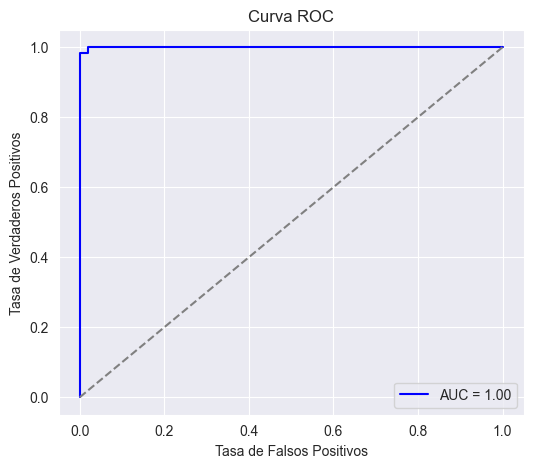

In [12]:
# Graficar la curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

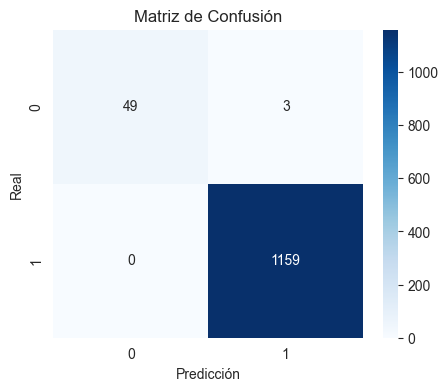

In [13]:
# Matriz de confusión
matriz = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
import seaborn as sns
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

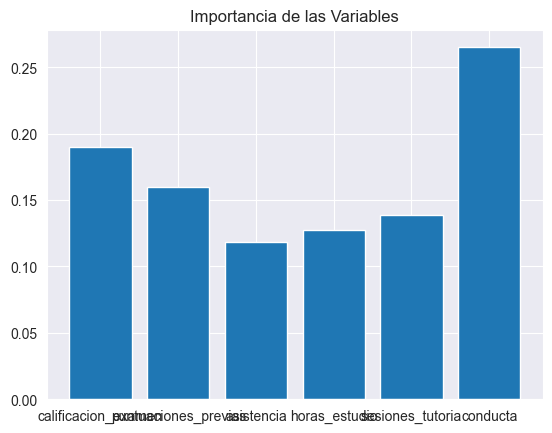

In [14]:
# Importancia de las variables
importancias = clf.feature_importances_
plt.bar(X.columns, importancias)
plt.title('Importancia de las Variables')
plt.show()